## Create the training pipeline

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

In [2]:
IMAGES_BASE_PATH = 'train/images/'
MASKS_BASE_PATH = 'train/masks/'

In [3]:
pre_disaster_image_names = os.listdir(IMAGES_BASE_PATH)
pre_disaster_image_names = [image_name for image_name in pre_disaster_image_names if image_name.endswith('_pre_disaster.png')]
pre_disaster_image_names = sorted(pre_disaster_image_names)
pre_disaster_image_names = [f'{IMAGES_BASE_PATH}{image_name}' for image_name in pre_disaster_image_names]
print(len(pre_disaster_image_names))
print(pre_disaster_image_names[:3])

post_disaster_image_names = os.listdir(IMAGES_BASE_PATH)
post_disaster_image_names = [image_name for image_name in post_disaster_image_names if image_name.endswith('_post_disaster.png')]
post_disaster_image_names = sorted(post_disaster_image_names)
post_disaster_image_names = [f'{IMAGES_BASE_PATH}{image_name}' for image_name in post_disaster_image_names]
print(len(post_disaster_image_names))
print(post_disaster_image_names[:3])

mask_image_names = os.listdir(MASKS_BASE_PATH)
mask_image_names = [image_name for image_name in mask_image_names if image_name.endswith('_post_disaster.png')]
mask_image_names = [image_name for image_name in mask_image_names if not image_name.startswith('house_seg_')]
mask_image_names = sorted(mask_image_names)
mask_image_names = [f'{MASKS_BASE_PATH}{image_name}' for image_name in mask_image_names]
print(len(mask_image_names))
print(mask_image_names[:3])

2799
['train/images/guatemala-volcano_00000000_pre_disaster.png', 'train/images/guatemala-volcano_00000001_pre_disaster.png', 'train/images/guatemala-volcano_00000002_pre_disaster.png']
2799
['train/images/guatemala-volcano_00000000_post_disaster.png', 'train/images/guatemala-volcano_00000001_post_disaster.png', 'train/images/guatemala-volcano_00000002_post_disaster.png']
2799
['train/masks/guatemala-volcano_00000000_post_disaster.png', 'train/masks/guatemala-volcano_00000001_post_disaster.png', 'train/masks/guatemala-volcano_00000002_post_disaster.png']


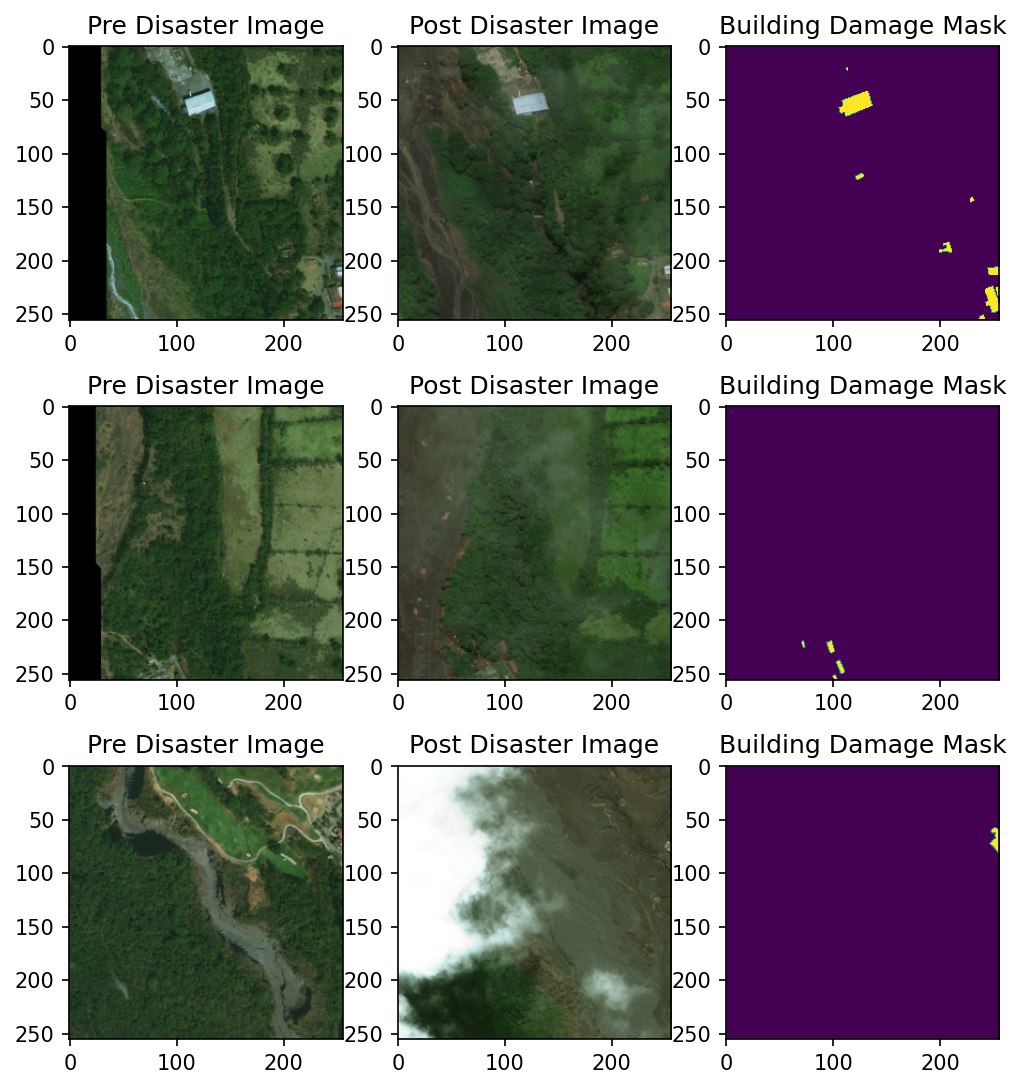

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(8,9))
fig.set_dpi(150)
offset = 0
for idx in range(3):
    pre_disaster_img = pltimg.imread(pre_disaster_image_names[idx + offset])
    post_disaster_img = plt.imread(post_disaster_image_names[idx + offset])
    mask_damage = pltimg.imread(mask_image_names[idx + offset])
    ax[idx][0].imshow(pre_disaster_img)
    ax[idx][0].set_title('Pre Disaster Image')
    
    ax[idx][1].imshow(post_disaster_img)
    ax[idx][1].set_title('Post Disaster Image')
    
    ax[idx][2].imshow(mask_damage)
    ax[idx][2].set_title('Building Damage Mask')

In [5]:
TARGET_SHAPE_IMAGE = [256, 256, 3]
TARGET_SHAPE_MASK = [256, 256, 1]

In [6]:
m = len(pre_disaster_image_names)
i_h, i_w, i_c = TARGET_SHAPE_IMAGE
m_h, m_w, m_c = TARGET_SHAPE_MASK

In [9]:
class_weights = [0, 0, 0, 0, 0, 0]

for image in tqdm(mask_image_names):
    img = Image.open(image)
    img = np.array(img)
    ctr = np.unique(img, return_counts=True)
    for i in range(len(ctr[0])):
        class_weights[ctr[0][i]] += ctr[1][i]
    
print(class_weights)
class_weights = np.array(class_weights)
class_weights = np.sum(class_weights) / (6 * class_weights)
print(class_weights)

100%|██████████| 2799/2799 [00:04<00:00, 575.17it/s]

[173845067, 7279509, 941842, 950827, 363237, 54782]
[1.75860866e-01 4.19980853e+00 3.24603745e+01 3.21536347e+01
 8.41669323e+01 5.58076448e+02]


In [10]:
def get_image_with_mask(pre_name, post_name, mask_name):
    pre_img = tf.io.read_file(pre_name)
    pre_img = tf.image.decode_png(pre_img)
    pre_img = tf.image.resize(pre_img, (i_w, i_h))
    
    post_img = tf.io.read_file(post_name)
    post_img = tf.image.decode_png(post_img)
    post_img = tf.image.resize(post_img, (i_w, i_h))
    
    mask = tf.io.read_file(mask_name)
    mask = tf.image.decode_png(mask)
    mask = tf.image.resize(mask, (m_w, m_h))

    return pre_img, post_img, mask

def scale_img(pre_image, post_image, mask):
    return (pre_image / 255., post_image / 255.), mask

def add_sample_weights(input_images, mask):
    global class_weights
    cw = tf.constant(class_weights)
    # class_weights = class_weights/tf.reduce_sum(class_weights)

    sample_weights = tf.gather(cw, indices=tf.cast(mask, tf.int32))

    return input_images, mask, sample_weights

In [11]:
pre_disaster_dataset = tf.data.Dataset.from_tensor_slices(pre_disaster_image_names)
post_disaster_dataset = tf.data.Dataset.from_tensor_slices(post_disaster_image_names)
masks_dataset = tf.data.Dataset.from_tensor_slices(mask_image_names)

In [12]:
dataset = tf.data.Dataset.zip((pre_disaster_dataset, post_disaster_dataset, masks_dataset))
dataset = dataset.map(get_image_with_mask).map(scale_img).map(add_sample_weights)

In [13]:
for input_img, mask, weights in dataset.take(1):
    print('Input: ', input_img)
    print('Mask: ', mask)

Input:  (<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.20784314, 0.3137255 , 0.1764706 ],
        [0.22745098, 0.32941177, 0.18431373],
        [0.19607843, 0.28235295, 0.14901961]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.19607843, 0.30980393, 0.16862746],
        [0.2       , 0.30980393, 0.16862746],
        [0.16078432, 0.2509804 , 0.13333334]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.18039216, 0.28627452, 0.16078432],
        [0.18039216, 0.2784314 , 0.15294118],
        [0.16862746, 0.25490198, 0.13725491]],

       ...,

       [[0.        , 0.        , 0.        ],
    

In [14]:
m = len(dataset)
train_size = int(m * 0.8)

train_set, val_set = dataset.take(train_size).batch(64), dataset.skip(train_size).batch(64)
print(len(train_set))
print(len(val_set))

35
9


## Model to classify the building damage

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, Lambda, Subtract
from tensorflow.keras.losses import binary_crossentropy

In [16]:
def EncoderMiniBlock(inputs, name, order, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    
    conv = BatchNormalization(name=f'{name}_batch_normalization_{order}')(conv, training=False)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2,2), padding='same')(prev_layer_input)
    
    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    return conv

In [18]:
def UNet(inputs, name, n_filters=32, n_classes=3):
    cb1 = EncoderMiniBlock(inputs, name=name, n_filters=n_filters, dropout_prob=0, max_pooling=True, order=0)
    cb2 = EncoderMiniBlock(cb1[0], name=name, n_filters=2 * n_filters, dropout_prob=0, max_pooling=True, order=1)
    cb3 = EncoderMiniBlock(cb2[0], name=name, n_filters=4 * n_filters, dropout_prob=0, max_pooling=True, order=2)
    cb4 = EncoderMiniBlock(cb3[0], name=name, n_filters=8 * n_filters, dropout_prob=0.3, max_pooling=True, order=3)
    cb5 = EncoderMiniBlock(cb4[0], name=name, n_filters=16 * n_filters, dropout_prob=0.3, max_pooling=False, order=4) 
    
    ub6 = DecoderMiniBlock(cb5[0], cb4[1], 8 * n_filters)
    ub7 = DecoderMiniBlock(ub6, cb3[1], 4 * n_filters)
    ub8 = DecoderMiniBlock(ub7, cb2[1], 2 * n_filters)
    ub9 = DecoderMiniBlock(ub8, cb1[1], n_filters)
    
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(ub9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

In [19]:
def DamageAssessmentBlock(pre_layer_input, post_layer_input, prev_layer_input=None, conv_kernel_size=3, conv_n_filters=16, upconv_n_filters=16, norm=True):
    next_input = Subtract()([pre_layer_input, post_layer_input])
    
    if prev_layer_input != None:
        up = Conv2DTranspose(upconv_n_filters, (3, 3), strides=(2,2), padding='same')(prev_layer_input)
        next_input = concatenate([next_input, up], axis=3)
    
    conv = Conv2D(conv_n_filters, conv_kernel_size, activation='relu', padding='same', kernel_initializer='HeNormal')(next_input)
    if norm:
        conv = BatchNormalization()(conv, training=False)
    
    return conv

In [20]:
class SiamUNetClassifier():
    def __init__(self, input_shape=(256, 256, 3)):        
        self.pre_input = Input(input_shape)
        self.post_input = Input(input_shape)
        
        self.pre_unet = UNet(self.pre_input, 'pre', n_filters=16, n_classes=2)
        self.post_unet = UNet(self.post_input, 'post', n_filters=16, n_classes=2)
        
        self.init_UNET()
        
        # Add the layers to perform damage assessment
        damage_classifier_block0 = DamageAssessmentBlock(
            self.pre_unet.get_layer('pre_batch_normalization_4').output,
            self.post_unet.get_layer('post_batch_normalization_4').output,
            conv_n_filters=256
        )
        
        damage_classifier_block1 = DamageAssessmentBlock(
            self.pre_unet.get_layer('pre_batch_normalization_3').output,
            self.post_unet.get_layer('post_batch_normalization_3').output,
            prev_layer_input=damage_classifier_block0,
            conv_n_filters=256,
            upconv_n_filters=128,
        )
        
        damage_classifier_block2 = DamageAssessmentBlock(
            self.pre_unet.get_layer('pre_batch_normalization_2').output,
            self.post_unet.get_layer('post_batch_normalization_2').output,
            prev_layer_input=damage_classifier_block1,
            conv_n_filters=128,
            upconv_n_filters=64
        )
        
        damage_classifier_block3 = DamageAssessmentBlock(
            self.pre_unet.get_layer('pre_batch_normalization_1').output,
            self.post_unet.get_layer('post_batch_normalization_1').output,
            prev_layer_input=damage_classifier_block2,
            conv_n_filters=64,
            upconv_n_filters=32
        )
        
        output = DamageAssessmentBlock(
            self.pre_unet.get_layer('pre_batch_normalization_0').output,
            self.post_unet.get_layer('post_batch_normalization_0').output,
            prev_layer_input=damage_classifier_block3,
            conv_n_filters=6,
            upconv_n_filters=16,
            conv_kernel_size=1,
            norm=False
        )        
        
        self.model = tf.keras.Model(inputs=[self.pre_input, self.post_input], outputs=output)
        
    def init_UNET(self):
        pre_disaster_weights_path = 'pre_disaster_segmentation-correct-weights-22-epochs.h5'
        post_disaster_weights_path = 'post_disaster_segmentation-correct-weights-10-epochs.h5'
        
        self.pre_unet.load_weights(pre_disaster_weights_path)
        self.post_unet.load_weights(post_disaster_weights_path)
        
        for layer in self.pre_unet.layers:
            layer.trainable = False
            
        for layer in self.post_unet.layers:
            layer.trainable = False

In [21]:
clf = SiamUNetClassifier()

In [22]:
clf.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                           

In [23]:
clf.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
clf.model.load_weights('damage-assesment-weights.h5')

In [68]:
results = clf.model.fit(train_set, batch_size=64, epochs=20, validation_data=val_set)

Epoch 1/20
35/35 [==============================] - 30s 869ms/step - loss: 0.9603 - accuracy: 0.8054 - val_loss: 0.5164 - val_accuracy: 0.9207
Epoch 2/20
35/35 [==============================] - 30s 866ms/step - loss: 0.9789 - accuracy: 0.8069 - val_loss: 0.6093 - val_accuracy: 0.9427
Epoch 3/20
35/35 [==============================] - 31s 880ms/step - loss: 0.9883 - accuracy: 0.8086 - val_loss: 0.5357 - val_accuracy: 0.9306
Epoch 4/20
35/35 [==============================] - 30s 874ms/step - loss: 1.0025 - accuracy: 0.8105 - val_loss: 0.5432 - val_accuracy: 0.9276
Epoch 5/20
35/35 [==============================] - 31s 880ms/step - loss: 1.0585 - accuracy: 0.8024 - val_loss: 0.6490 - val_accuracy: 0.9496
Epoch 6/20
35/35 [==============================] - 30s 870ms/step - loss: 1.0109 - accuracy: 0.8029 - val_loss: 0.5973 - val_accuracy: 0.9366
Epoch 7/20
35/35 [==============================] - 30s 871ms/step - loss: 0.9596 - accuracy: 0.8074 - val_loss: 0.5570 - val_accuracy: 0.9344

In [58]:
clf.model.save_weights('damage-assesment-weights.h5')

## Evaluate the results

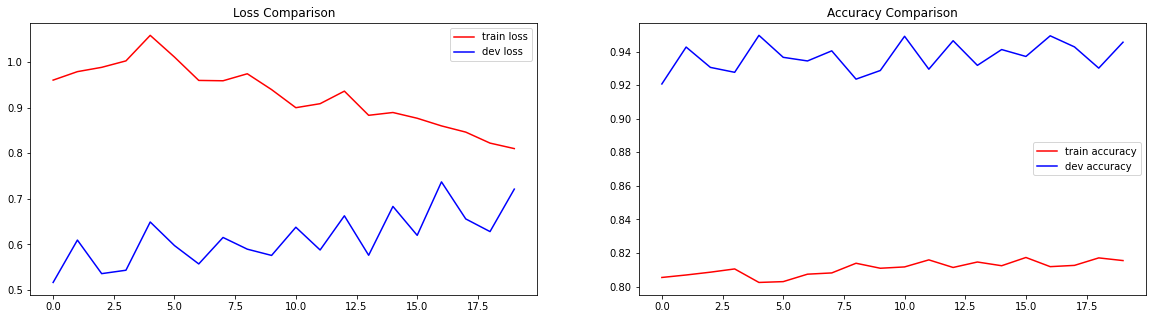

In [69]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [70]:
clf.model.evaluate(val_set)

9/9 [==============================] - 9s 405ms/step - loss: 0.7211 - accuracy: 0.9456


[0.7211412787437439, 0.9455630779266357]

In [71]:
from PIL import Image
import matplotlib.image as im

def preprocess_image(img):
    img = img.resize((i_h, i_w))
    img = np.array(img)
    img = img / 255.
    img = img[np.newaxis, ...]
    return img

def VisualizeResults(index):
    print(post_disaster_image_names[index])
    
    pre_img = preprocess_image(Image.open(pre_disaster_image_names[index]).convert('RGB'))
    post_img = preprocess_image(Image.open(post_disaster_image_names[index]).convert('RGB'))    

    actual_mask = im.imread(mask_image_names[index])
    
    pred_y = clf.model.predict((pre_img, post_img))
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = pred_mask.numpy()
    pred_mask = pred_mask.reshape((i_h, i_w))
    
    print(np.unique(actual_mask, return_counts=True))
    print(np.unique(pred_mask, return_counts=True))

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(post_img[0])
    arr[0].set_title('Post Disaster Image')
    arr[1].imshow(actual_mask)
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask)
    arr[2].set_title('Predicted Masked Image ')

train/images/hurricane-michael_00000225_post_disaster.png
(array([0.        , 0.00392157, 0.00784314, 0.01176471], dtype=float32), array([59591,  1171,   845,  3929]))
(array([0, 1, 2, 3, 4, 5]), array([50241,  3272,  4894,  5547,  1213,   369]))
train/images/hurricane-michael_00000228_post_disaster.png
(array([0.        , 0.00392157, 0.00784314], dtype=float32), array([62481,  1943,  1112]))
(array([0, 1, 2, 3, 4, 5]), array([57463,   606,  5345,     4,  1055,  1063]))
train/images/hurricane-michael_00000230_post_disaster.png
(array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784], dtype=float32), array([60182,  4007,  1031,   188,    22,   106]))
(array([0, 1, 2, 3, 4, 5]), array([44094,  3702, 13523,   384,  1920,  1913]))


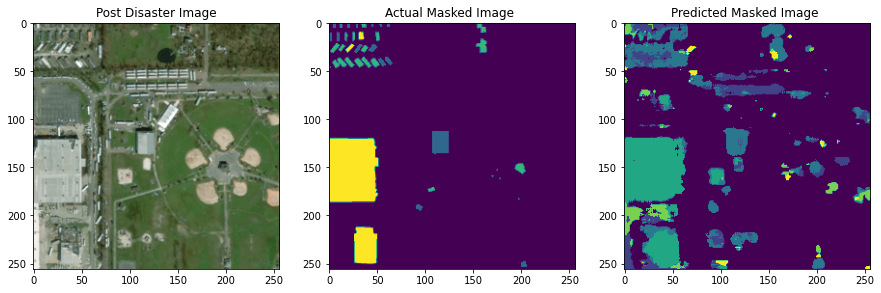

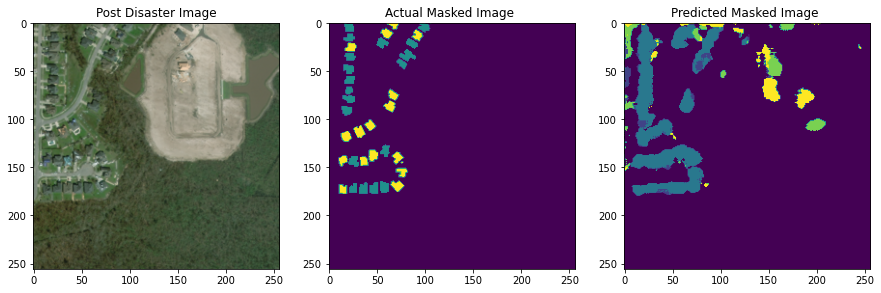

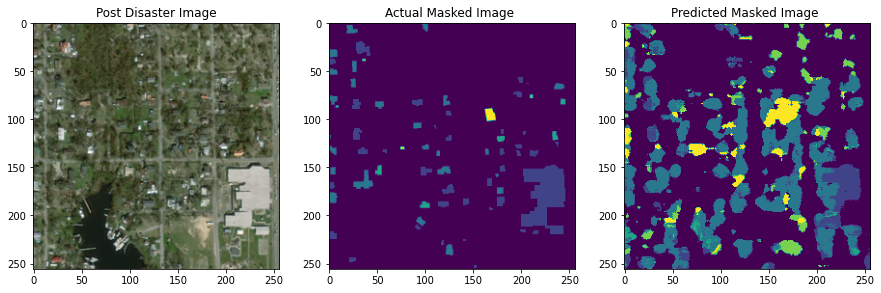

In [72]:
offset = 1031
for i in range(0, 3):
    VisualizeResults(offset + i)

(array([0, 1, 2, 3, 4, 5]), array([30675, 14664, 16461,   313,  3048,   375]))


Text(0.5, 1.0, 'Predicted Masked Image ')

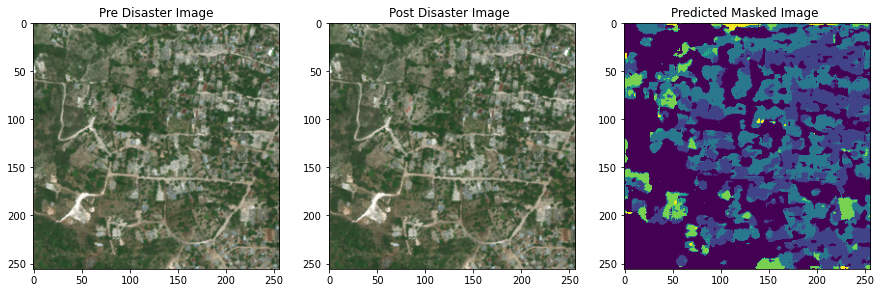

In [76]:
pre_img = preprocess_image(Image.open('six.png').convert('RGB'))
post_img = preprocess_image(Image.open('six.png').convert('RGB'))

pred_y = clf.model.predict((pre_img, post_img))
pred_mask = tf.argmax(pred_y[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
pred_mask = pred_mask.numpy()
pred_mask = pred_mask.reshape((i_h, i_w))

print(np.unique(pred_mask, return_counts=True))

fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(pre_img[0])
arr[0].set_title('Pre Disaster Image')
arr[1].imshow(post_img[0])
arr[1].set_title('Post Disaster Image ')
arr[2].imshow(pred_mask)
arr[2].set_title('Predicted Masked Image ')